In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn import preprocessing, model_selection
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from itertools import combinations 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import os

2023-04-25 10:12:12.900116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-25 10:12:12.900188: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
def greatest_class(prediction):
    max_item = max(prediction)
    return prediction.tolist().index(max_item)

def impute(x, y, imputer = None):
    if imputer:
        _x = pd.DataFrame(imputer.transform(x), columns = x.columns)
        return _x, y, imputer
    
    imputer = KNNImputer(n_neighbors=3)
    _x = pd.DataFrame(imputer.fit_transform(x), columns = x.columns)
    return _x, y, imputer

def oversample(x, y):
    x_smote, y_smote = SMOTETomek().fit_resample(x, y)
    return x_smote, y_smote

def select_rows(x, y, cols):
    df = pd.DataFrame(x, columns = cols)
    df = df[df.columns.drop(list(df.filter(regex='Positive discriminator|MTS|Hospitalisation')))]
    return df.to_numpy(), y, df.columns

def augment(x, y, augmenter = None):
    x = x.fillna(-1)
    x, augmenter = _add_interactions(x, augmenter)
    return x, y, augmenter, x.columns

def _add_interactions(df, augmenter):
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]

    if augmenter:
        df = augmenter.transform(df)
    else:
        augmenter = PolynomialFeatures(interaction_only=True, include_bias=False)
        df = augmenter.fit_transform(df)

    df = pd.DataFrame(df)
    df.columns = colnames
    
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis=1)
    
    return df, augmenter

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df = pd.read_csv('data.csv')
dataset = df[(df['Respiratory rate'].notnull() | df['Heart rate'].notnull() | df['Temperature'].notnull() | df['Oxygen saturation'].notnull()) & df['Age'].notnull()]

In [7]:
data = dataset

In [8]:
min(data['Oxygen saturation'].dropna().values)

40.0

In [9]:
fernando = data[data['Hospital '] == 'Fernando Fonseca Hospital']
juliana = data[data['Hospital '] == 'Juliana Childrens Hospital']
sophia = data[data['Hospital '] == 'Sophia Childrens Hospital']
mary = data[data['Hospital '] == 'St Mary']

In [55]:
sophia.sample(1).to_dict('list')

{'Patientnumber': ['19199'],
 'Hospital ': ['Sophia Childrens Hospital'],
 'Arrival date': ['14.06.2009'],
 'Age': [12.03],
 'Respiratory rate': [nan],
 'Heart rate': [88.0],
 'Temperature': [nan],
 'Oxygen saturation': [100.0],
 'Original MTS': ['Urgent'],
 'MTS 1': ['Urgent'],
 'Positive discriminator': ['Moderate pain'],
 'Presenting problem': ['Neurological'],
 'Hospitalisation': ['no']}

In [10]:
def scale(x, y, scaler = None):
    if scaler:
        return pd.DataFrame(scaler.transform(x), columns = x.columns), y, scaler
    
    scaler = MinMaxScaler()
    norm_data = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)

    return norm_data, y, scaler

In [59]:
def ohe(data):
    variables = data[['Presenting problem']]
    dummmies = pd.get_dummies(variables)
    df_ordinal_removed = data.drop(['Presenting problem'], axis=1)
    data = pd.concat([dummmies, df_ordinal_removed], axis=1)
    import pdb; pdb.set_trace()
    variables = data[['Positive discriminator']]
    dummmies = pd.get_dummies(variables)
    df_discriminator_removed = data.drop(['Positive discriminator'], axis=1)
    data = pd.concat([dummmies, df_discriminator_removed], axis=1)

    data['Hospitalisation'] = data['Hospitalisation'].replace({ 'no': 0, 'yes': 1})
    return data

In [65]:
def gen_folds(data, fold):
    num_folds = 10
    fold_no = 1
    kfold = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True)

    data = data.drop([
        'Patientnumber', 'Hospital ', 'Arrival date', 'MTS 1'
    ], axis = 1)
        
    X = data.drop(['Original MTS'], axis = 1)
    Y = data.filter(['Original MTS'])
    
    X = ohe(X)
    Y = Y['Original MTS'].replace({ 'Non urgent': 0, 'Standard': 1, 'Urgent': 2, 'Very urgent': 3, 'Emergent': 4})
       
    X, Y, _, columns = augment(X, Y)
    X[(X < 0) & (X != np.nan)] = np.nan
        
    for train, test in kfold.split(X, Y):
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        print('TRAIN: Normalizing data')
        x_train, y_train, escaler = scale(X.loc[train], Y.loc[train])
        print('TRAIN: Imputing')
        x_train, y_train, imputer = impute(x_train, y_train)
        print('TRAIN: Oversampling')
        x_train, y_train = oversample(x_train, y_train)
        print('TRAIN: Selecting rows')
        x_train, y_train, _ = select_rows(x_train, y_train, columns)
        
        print('TEST: Normalizing data')
        x_test, y_test, _ = scale(X.loc[test], Y.loc[test], escaler)
        print('TEST: Imputing')
        x_test, y_test, _ = impute(x_test, y_test, imputer)
        print('TEST: Selecting rows')
        x_test, y_test, filtered_columns = select_rows(x_test, y_test, columns)
        
        import pdb; pdb.set_trace()
        x_train_df = pd.DataFrame(x_train, columns = filtered_columns)
    
        y_train_df = pd.DataFrame(y_train.values, columns = ['MTS'])
        x_test_df  = pd.DataFrame(x_test, columns = filtered_columns)
        y_test_df  = pd.DataFrame(y_test.values, columns = ['MTS'])
        
        save_folds(x_train_df, y_train_df, x_test_df, y_test_df, fold, fold_no)
                
        fold_no = fold_no + 1

In [13]:
import random

In [14]:
cols = ['Presenting problem_Dyspnea', 'Presenting problem_Ear, nose, throat',
       'Presenting problem_Fever without source',
       'Presenting problem_Gastro-intestinal',
       'Presenting problem_Neurological', 'Presenting problem_Other problems',
       'Presenting problem_Rash', 'Presenting problem_Trauma',
       'Presenting problem_Urinary tract problems',
       'Presenting problem_Wounds',
       'Presenting problem_local infection/abscess', 'Age', 'Respiratory rate',
       'Heart rate', 'Temperature', 'Oxygen saturation',
       'Presenting problem_Dyspnea_Age',
       'Presenting problem_Dyspnea_Respiratory rate',
       'Presenting problem_Dyspnea_Heart rate',
       'Presenting problem_Dyspnea_Temperature',
       'Presenting problem_Dyspnea_Oxygen saturation',
       'Presenting problem_Ear, nose, throat_Age',
       'Presenting problem_Ear, nose, throat_Respiratory rate',
       'Presenting problem_Ear, nose, throat_Heart rate',
       'Presenting problem_Ear, nose, throat_Temperature',
       'Presenting problem_Ear, nose, throat_Oxygen saturation',
       'Presenting problem_Fever without source_Age',
       'Presenting problem_Fever without source_Respiratory rate',
       'Presenting problem_Fever without source_Heart rate',
       'Presenting problem_Fever without source_Temperature',
       'Presenting problem_Fever without source_Oxygen saturation',
       'Presenting problem_Gastro-intestinal_Age',
       'Presenting problem_Gastro-intestinal_Respiratory rate',
       'Presenting problem_Gastro-intestinal_Heart rate',
       'Presenting problem_Gastro-intestinal_Temperature',
       'Presenting problem_Gastro-intestinal_Oxygen saturation',
       'Presenting problem_Neurological_Age',
       'Presenting problem_Neurological_Respiratory rate',
       'Presenting problem_Neurological_Heart rate',
       'Presenting problem_Neurological_Temperature',
       'Presenting problem_Neurological_Oxygen saturation',
       'Presenting problem_Other problems_Age',
       'Presenting problem_Other problems_Respiratory rate',
       'Presenting problem_Other problems_Heart rate',
       'Presenting problem_Other problems_Temperature',
       'Presenting problem_Other problems_Oxygen saturation',
       'Presenting problem_Rash_Age',
       'Presenting problem_Rash_Respiratory rate',
       'Presenting problem_Rash_Heart rate',
       'Presenting problem_Rash_Temperature',
       'Presenting problem_Rash_Oxygen saturation',
       'Presenting problem_Trauma_Age',
       'Presenting problem_Trauma_Respiratory rate',
       'Presenting problem_Trauma_Heart rate',
       'Presenting problem_Trauma_Temperature',
       'Presenting problem_Trauma_Oxygen saturation',
       'Presenting problem_Urinary tract problems_Age',
       'Presenting problem_Urinary tract problems_Respiratory rate',
       'Presenting problem_Urinary tract problems_Heart rate',
       'Presenting problem_Urinary tract problems_Temperature',
       'Presenting problem_Urinary tract problems_Oxygen saturation',
       'Presenting problem_Wounds_Age',
       'Presenting problem_Wounds_Respiratory rate',
       'Presenting problem_Wounds_Heart rate',
       'Presenting problem_Wounds_Temperature',
       'Presenting problem_Wounds_Oxygen saturation',
       'Presenting problem_local infection/abscess_Age',
       'Presenting problem_local infection/abscess_Respiratory rate',
       'Presenting problem_local infection/abscess_Heart rate',
       'Presenting problem_local infection/abscess_Temperature',
       'Presenting problem_local infection/abscess_Oxygen saturation',
       'Age_Respiratory rate', 'Age_Heart rate', 'Age_Temperature',
       'Age_Oxygen saturation', 'Respiratory rate_Heart rate',
       'Respiratory rate_Temperature', 'Respiratory rate_Oxygen saturation',
       'Heart rate_Temperature', 'Heart rate_Oxygen saturation',
       'Temperature_Oxygen saturation']

In [15]:
def save_folds(x_train, y_train, x_test, y_test, fold, fold_no):
    path = 'folds/' + fold
    
    if not os.path.exists(path):
        os.makedirs(path)
        
    x_train.to_csv(path  + '/'  + str(fold_no) + '_x_train.csv', index=False)
    y_train.to_csv(path  + '/'  + str(fold_no) + '_y_train.csv', index=False)
    x_test.to_csv(path  + '/'  + str(fold_no) + '_x_test.csv', index=False)
    y_test.to_csv(path  + '/'  + str(fold_no) + '_y_test.csv', index=False)

In [18]:
def run_model(label, fold, model):
    num_folds = 10
    ids = list(range(1, num_folds + 1))
    
    for i in ids:
        x_train = pd.read_csv('folds/' + fold + '/' + str(i) + '_x_train.csv', index_col=False)
        y_train = pd.read_csv('folds/' + fold + '/' + str(i) + '_y_train.csv', index_col=False)
        x_test  = pd.read_csv('folds/' + fold + '/' + str(i) + '_x_test.csv', index_col=False)
        y_test  = pd.read_csv('folds/' + fold + '/' + str(i) + '_y_test.csv', index_col=False)
            
        y_train = np.ravel(y_train, order = 'C')
        y_test = np.ravel(y_test, order = 'C')
                 
        print('------------------------------------------------------------------------')
        print(f'Fold {i} ...')
        model(x_train.to_numpy(), y_train, x_test.to_numpy(), y_test, label, i)

In [24]:
def svm(x_train, y_train, x_test, y_test, label, fold_no):
    print('Fitting model')
    clf = SVC(decision_function_shape='ovr', kernel='rbf', C=100, gamma=100)
    clf.fit(x_train, y_train)

    print('Predicting')
    predicted = clf.decision_function(x_test)

    class_per_prediction = list(map(greatest_class, predicted))
    save_to_file([class_per_prediction, y_test], label, fold_no)

In [25]:
def mlp(x_train, y_train, x_test, y_test, label, fold_no):
    model = Sequential()
    model.add(Input(shape=(x_train.shape[1],)))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = 'relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(5, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

    print('Fitting model')
    history = model.fit(x_train, y_train, batch_size=64, epochs=50)
    scores = model.evaluate(x_test, y_test, verbose=0)

    print('Predicting')
    predicted = model.predict(x_test)

    class_per_prediction = list(map(greatest_class, predicted))
    save_to_file([class_per_prediction, y_test], label, fold_no)

In [26]:
def gb(x_train, y_train, x_test, y_test, label, fold_no):
    print('Fitting model')
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5)
    clf.fit(x_train, y_train)

    print('Predicting')
    score = clf.score(x_test, y_test)
    print(f'Score for fold {fold_no}: {score}')

    predicted = clf.predict(x_test)
    save_to_file([predicted, y_test], label, fold_no)

In [27]:
def ab(x_train, y_train, x_test, y_test, label, fold_no):
    print('Fitting model')
    clf = AdaBoostClassifier(n_estimators=100)
    clf.fit(x_train, y_train)

    print('Predicting')
    score = clf.score(x_test, y_test)
    print(f'Score for fold {fold_no}: {score}')

    predicted = clf.predict(x_test)
    save_to_file([predicted, y_test], label, fold_no)

In [61]:
def rf(x_train, y_train, x_test, y_test, label, fold_no):
    print('Fitting model')
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(x_train, y_train)
    
    # Save the model under the cwd
    pkl_filename = f"models/{label}-{fold_no}.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(clf, file)

    print('Predicting')
    score = clf.score(x_test, y_test)
    print(f'Score for fold {fold_no}: {score}')

#     features = list(zip(cols, clf.feature_importances_))
#     features.sort(key=lambda f: -f[1])
#     print(features)
#     import pdb; pdb.set_trace()
    predicted = clf.predict_proba(x_test)
    #mport pdb; pdb.set_trace()
    save_to_file([predicted, y_test], label, fold_no)

In [20]:
def knn(x_train, y_train, x_test, y_test, label, fold_no):
    print('Fitting model')
    clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(x_train, y_train)

    print('Predicting')
    score = clf.score(x_test, y_test)
    print(f'Score for fold {fold_no}: {score}')

    predicted = clf.predict(x_test)
    save_to_file([predicted, y_test], label, fold_no)

In [30]:
def dt(x_train, y_train, x_test, y_test, label, fold_no):
    print('Fitting model')
    clf = DecisionTreeClassifier(max_depth = 10, min_samples_split = 5, min_samples_leaf = 5)
    clf.fit(x_train, y_train)

    print('Predicting')
    score = clf.score(x_test, y_test)
    print(f'Score for fold {fold_no}: {score}')

    predicted = clf.predict(x_test)
    save_to_file([predicted, y_test], label, fold_no)

In [24]:
def save_to_file(predictions, tag, fold_no):
    path = 'results/' + tag + '/'
    
    if not os.path.exists(path):
        os.makedirs(path)    

    with open(path + str(fold_no) + '-predicted.txt', 'w+') as writer:
        writer.writelines(list(map(str, predictions[0])))
        writer.write("\n")
            
    with open(path + str(fold_no) + '-label.txt', 'w+') as writer:
        writer.writelines(list(map(str, predictions[1])))
        writer.write("\n")

# Run tests

In [22]:
import pickle

In [66]:
for i in range(10):
    gen_folds(pd.concat([sophia]).reset_index(drop=True), 'sophia/' + str(i))
    #run_model('sophia-svm/' + str(i), 'sophia/' + str(i), svm)
    #run_model('sophia-rf/' + str(i), 'sophia/' + str(i), rf)
    #run_model('sophia-mlp/' + str(i), 'sophia/' + str(i), mlp)
#     run_model('sophia-ab/' + str(i), 'sophia/' + str(i), ab)
#     run_model('sophia-knn/' + str(i), 'sophia/' + str(i), knn)
#     run_model('sophia-gb/' + str(i), 'sophia/' + str(i), gb)
#     run_model('sophia-dt/' + str(i), 'sophia/' + str(i), dt)
    print("============================ EXPERIMENT " + str(i) + " =========================\n")

> /tmp/ipykernel_39423/2452913622.py(7)ohe()
      5     data = pd.concat([dummmies, df_ordinal_removed], axis=1)
      6     import pdb; pdb.set_trace()
----> 7     variables = data[['Positive discriminator']]
      8     dummmies = pd.get_dummies(variables)
      9     df_discriminator_removed = data.drop(['Positive discriminator'], axis=1)

ipdb> c
------------------------------------------------------------------------
Training for fold 1 ...
TRAIN: Normalizing data
TRAIN: Imputing
TRAIN: Oversampling
TRAIN: Selecting rows
TEST: Normalizing data
TEST: Imputing
TEST: Selecting rows
> /tmp/ipykernel_39423/3161592438.py(40)gen_folds()
     38 
     39         import pdb; pdb.set_trace()
---> 40         x_train_df = pd.DataFrame(x_train, columns = filtered_columns)
     41 
     42         y_train_df = pd.DataFrame(y_train.values, columns = ['MTS'])

ipdb> filtered_columns
Index(['Presenting problem_Dyspnea', 'Presenting problem_Ear, nose, throat',
       'Presenting problem_Fever with

BdbQuit: 

<AxesSubplot:>

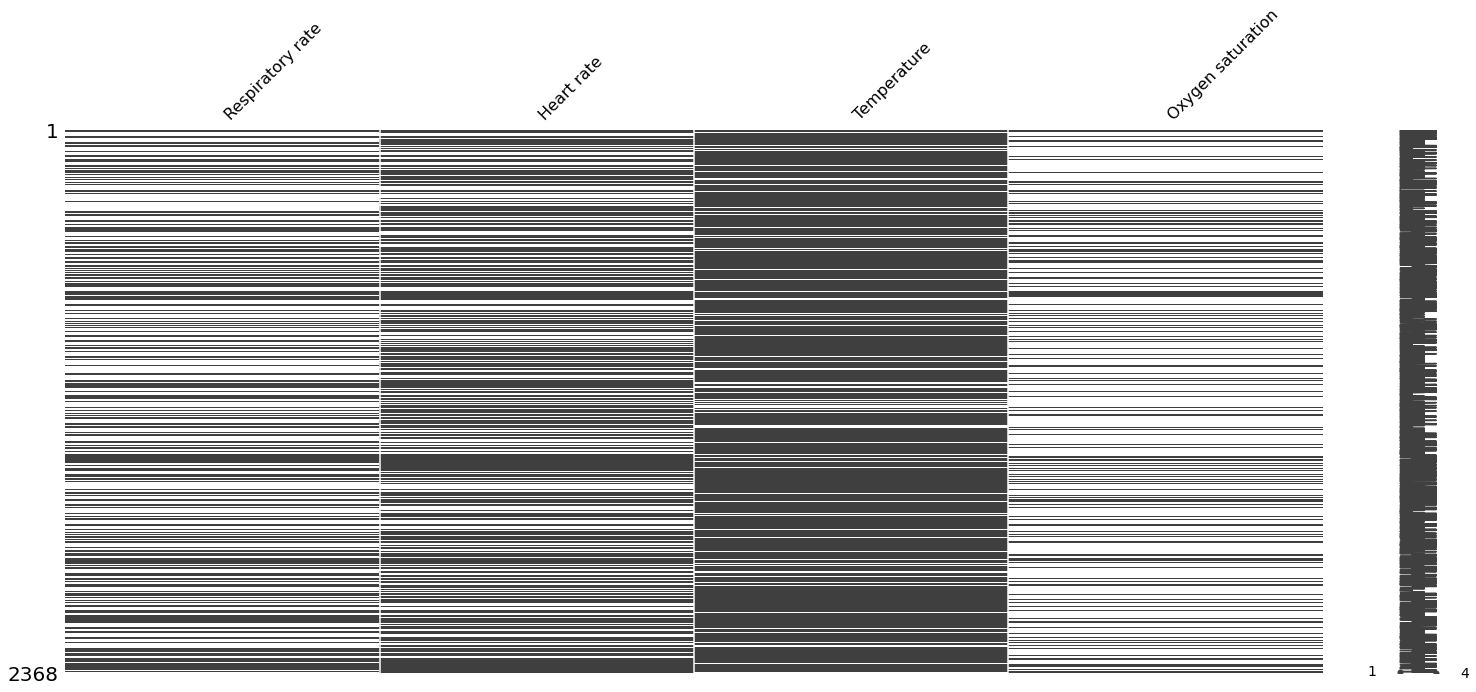

In [19]:
#juliana[juliana['Original MTS'] == 'Emergent']

msno.matrix(sophia[sophia['Original MTS'] == 'Standard'].filter(items=['Respiratory rate', 'Heart rate', 'Temperature', 'Oxygen saturation']))

In [10]:
v = sophia['Original MTS'].value_counts()
print('All to Emergent ratio: ' + str((v['Emergent'] / juliana.shape[0])))

All to Emergent ratio: 0.0842344906089926


<AxesSubplot:>

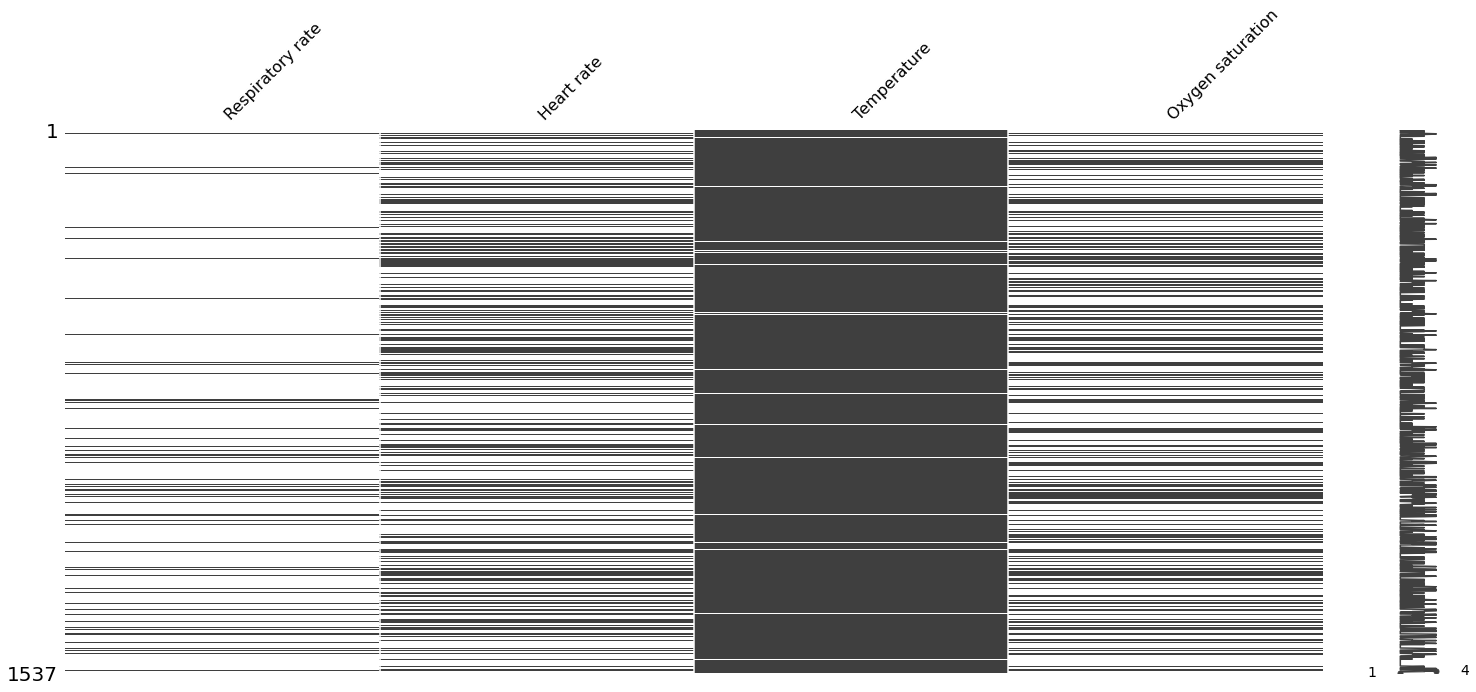

In [20]:
msno.matrix(juliana[juliana['Original MTS'] == 'Standard'].filter(items=['Respiratory rate', 'Heart rate', 'Temperature', 'Oxygen saturation']))

<AxesSubplot:>

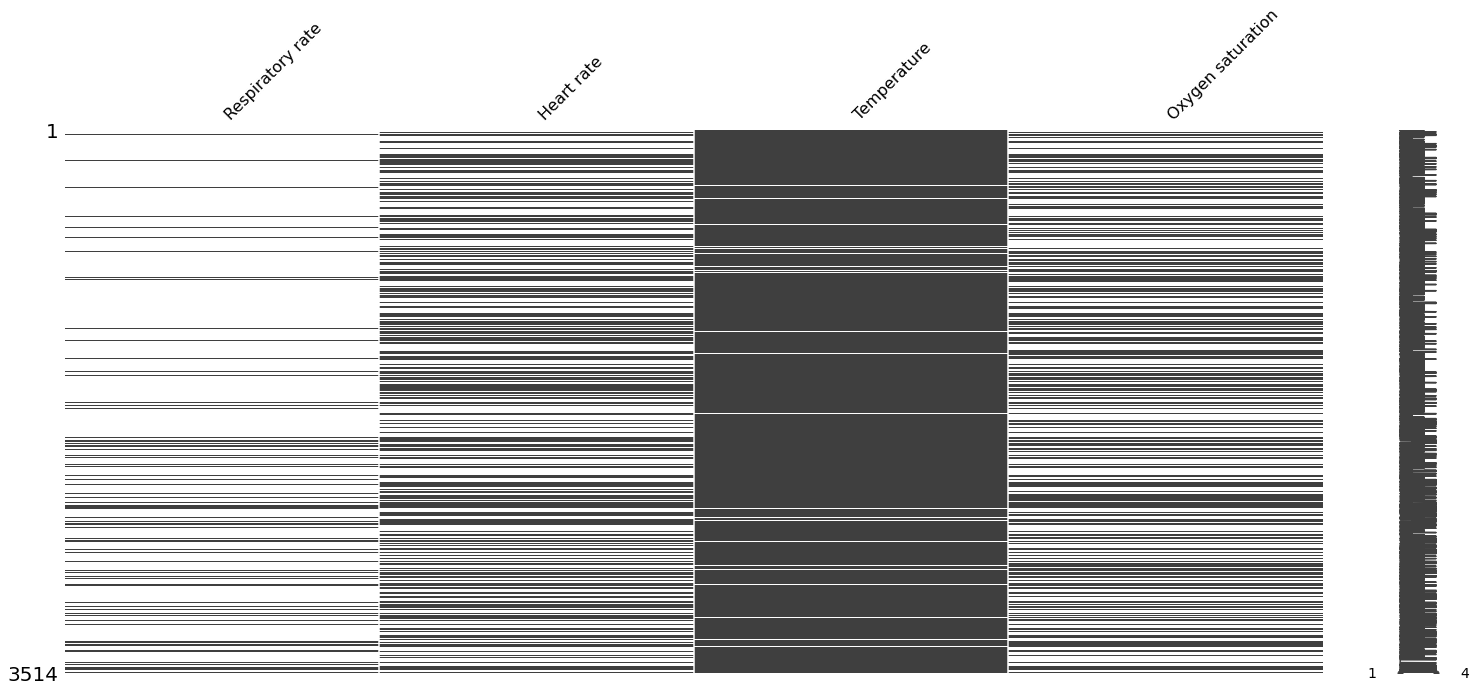

In [38]:
import missingno as msno
%matplotlib inline
msno.matrix(juliana.filter(items=['Respiratory rate', 'Heart rate', 'Temperature', 'Oxygen saturation']))

<AxesSubplot:>

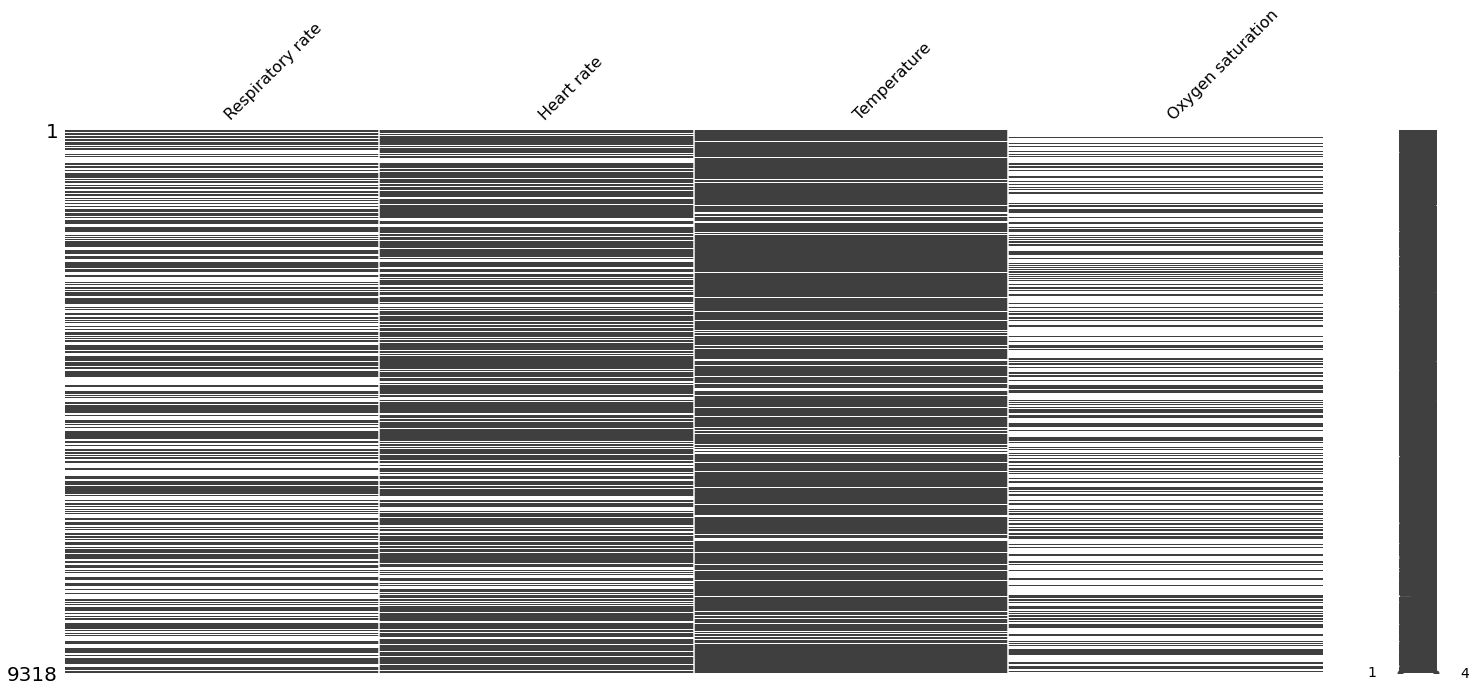

In [16]:
import missingno as msno
%matplotlib inline
msno.matrix(sophia.filter(items=['Respiratory rate', 'Heart rate', 'Temperature', 'Oxygen saturation']))

In [19]:
import matplotlib.pyplot as plt

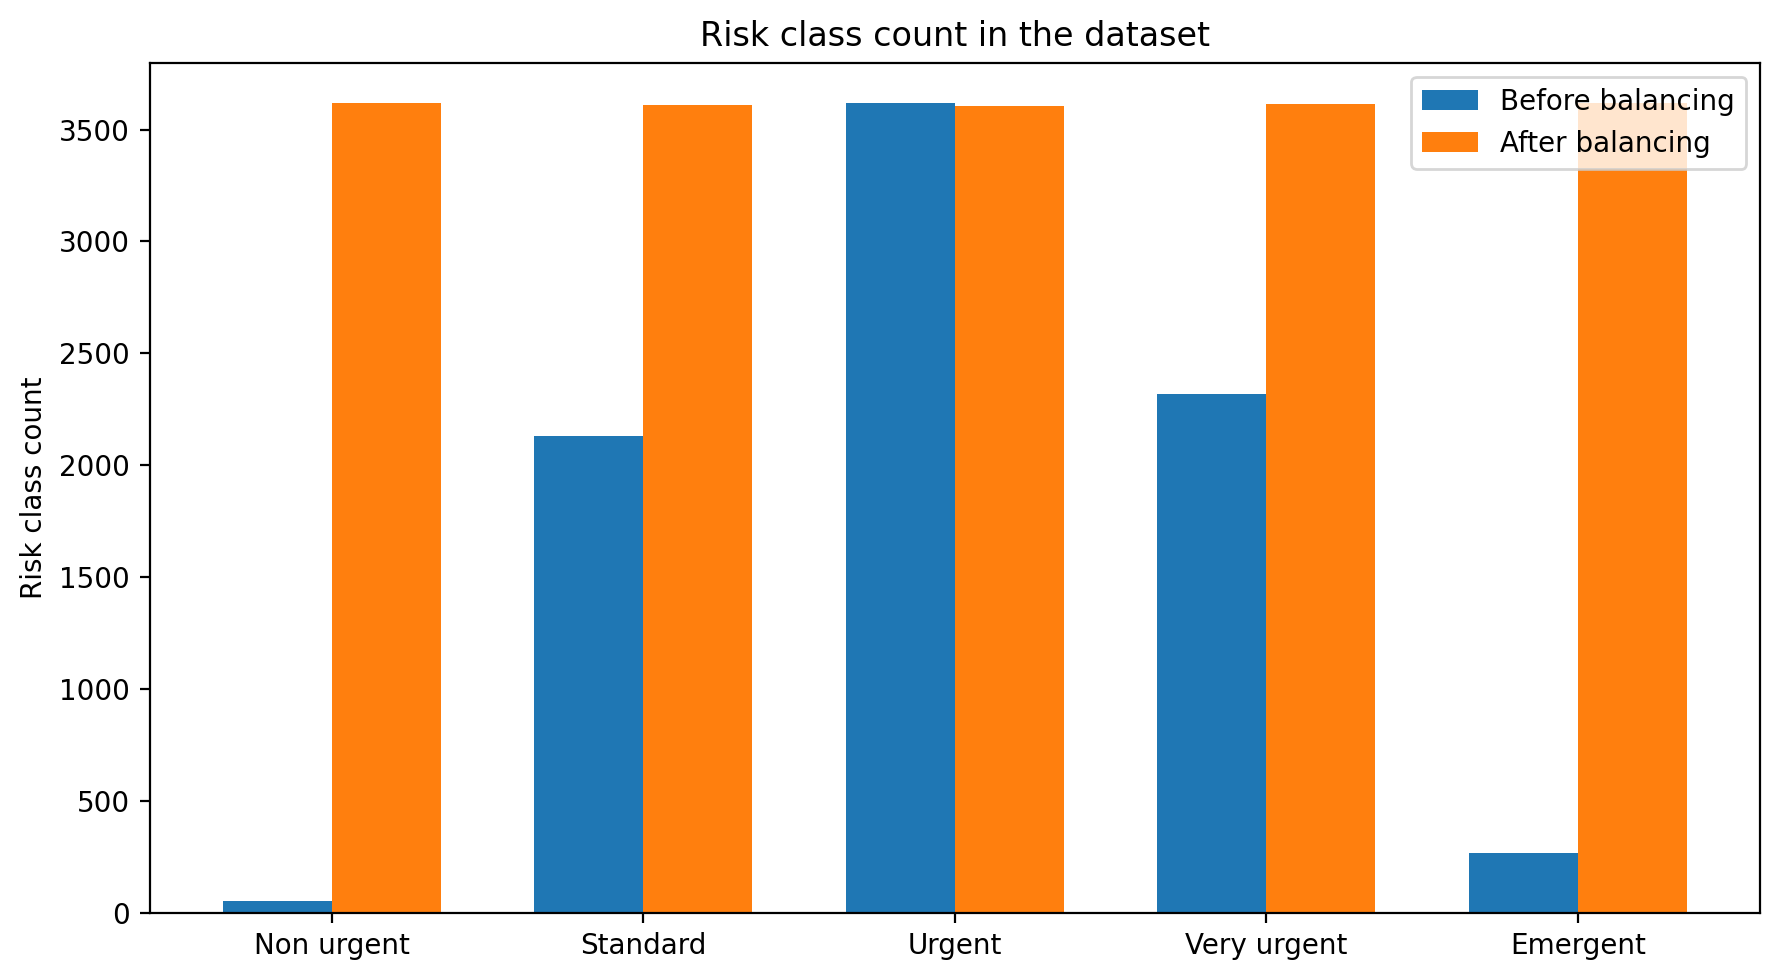

In [77]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Non urgent', 'Standard', 'Urgent', 'Very urgent', 'Emergent']
men_means = [  52, 2131, 3618, 2318,  267]
women_means = [3618, 3609, 3606, 3615, 3618]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Before balancing')
rects2 = ax.bar(x + width/2, women_means, width, label='After balancing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Risk class count')
ax.set_title('Risk class count in the dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# ax.set_ylim([0, 4200])
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)

fig.set_size_inches(9, 5)
fig.set_dpi(200)
fig.tight_layout()

plt.show()

## Training only RF with whole dataset

In [43]:
def rf_whole(x_train, y_train):
    print('Fitting model')
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(x_train, y_train)
    
    # Save the model under the cwd
    pkl_filename = f"final-model/rf.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(clf, file)

In [1]:
def run(data):
    data = data.drop([
        'Patientnumber', 'Hospital ', 'Arrival date', 'MTS 1'
    ], axis = 1)
        
    X = data.drop(['Original MTS'], axis = 1)
    Y = data.filter(['Original MTS'])
    
    X = ohe(X)
    Y = Y['Original MTS'].replace({ 'Non urgent': 0, 'Standard': 1, 'Urgent': 2, 'Very urgent': 3, 'Emergent': 4})
       
    X, Y, augmenter, columns = augment(X, Y)
    X[(X < 0) & (X != np.nan)] = np.nan
        
    print('TRAIN: Normalizing data')
    x_train, y_train, escaler = scale(X, Y)
    print('TRAIN: Imputing')
    x_train, y_train, imputer = impute(x_train, y_train)
    print('TRAIN: Oversampling')
    x_train, y_train = oversample(x_train, y_train)
    print('TRAIN: Selecting rows')
    x_train, y_train, _ = select_rows(x_train, y_train, columns)
    
    with open('final-model/scaler.pkl', 'wb') as file:
        pickle.dump(escaler, file)

    with open('final-model/imputer.pkl', 'wb') as file:
        pickle.dump(imputer, file)
    
    with open('final-model/augmenter.pkl', 'wb') as file:
        pickle.dump(augmenter, file)
    
    rf_whole(x_train, y_train)

In [48]:
run(sophia)

TRAIN: Normalizing data
TRAIN: Imputing
TRAIN: Oversampling
TRAIN: Selecting rows
Fitting model


In [85]:
sophia.sample()

,Patientnumber,Hospital,Arrival date,Age,Respiratory rate,Heart rate,Temperature,Oxygen saturation,Original MTS,MTS 1,Positive discriminator,Presenting problem,Hospitalisation
19577,19578,Sophia Childrens Hospital,02.07.2009,3.2,NaN,NaN,36.7,NaN,Urgent,Urgent,Significant history,Other problems,yes
